# Technical Report for NHS

This notebook accompanies the NHS business report and includes code for the depicted charts and figures

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Data Loading
# ------------------------------------------------------------
# appointments_regional.csv -> ar
ar = pd.read_csv('appointments_regional.csv')
# national_categories.xlsx -> nc
nc = pd.read_excel('national_categories.xlsx')
# actual_duration.csv -> ad
ad = pd.read_csv('actual_duration.csv')
# tweets.csv -> tw
tw = pd.read_csv('tweets.csv')

# Convert date columns to datetime
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'])
nc['appointment_month'] = pd.to_datetime(nc['appointment_month'])
if 'appointment_date' in ar.columns:
    ar['appointment_date'] = pd.to_datetime(ar['appointment_date'])


In [47]:
# ------------------------------------------------------------
# 1. Data Integrity Checks
# ------------------------------------------------------------
# 1. Integrity in ar (regional appointments)
mandatory_ar = ['appointment_month', 'count_of_appointments', 'appointment_status',
                'time_between_book_and_appointment']
completeness_ar = 100 * ar[mandatory_ar].notna().mean()
print('ar mandatory‐field completeness (%)')
print(completeness_ar)

# 2. Integrity in nc (national categories)
mandatory_nc = ['appointment_month', 'service_setting', 'national_category',
                'context_type', 'count_of_appointments']
completeness_nc = 100 * nc[mandatory_nc].notna().mean()
print('\nnc mandatory‐field completeness (%)')
print(completeness_nc)

# 3. Data Integrity Checks for actual_duration (ad)
mandatory_ad = ['appointment_date', 'actual_duration', 'count_of_appointments']
completeness_ad = 100 * ad[mandatory_ad].notna().mean()
print('\nad mandatory-field completeness (%):')
print(completeness_ad)

ar mandatory‐field completeness (%)
appointment_month                    100.0
count_of_appointments                100.0
appointment_status                   100.0
time_between_book_and_appointment    100.0
dtype: float64

nc mandatory‐field completeness (%)
appointment_month        100.0
service_setting          100.0
national_category        100.0
context_type             100.0
count_of_appointments    100.0
dtype: float64

ad mandatory-field completeness (%):
appointment_date         100.0
actual_duration          100.0
count_of_appointments    100.0
dtype: float64


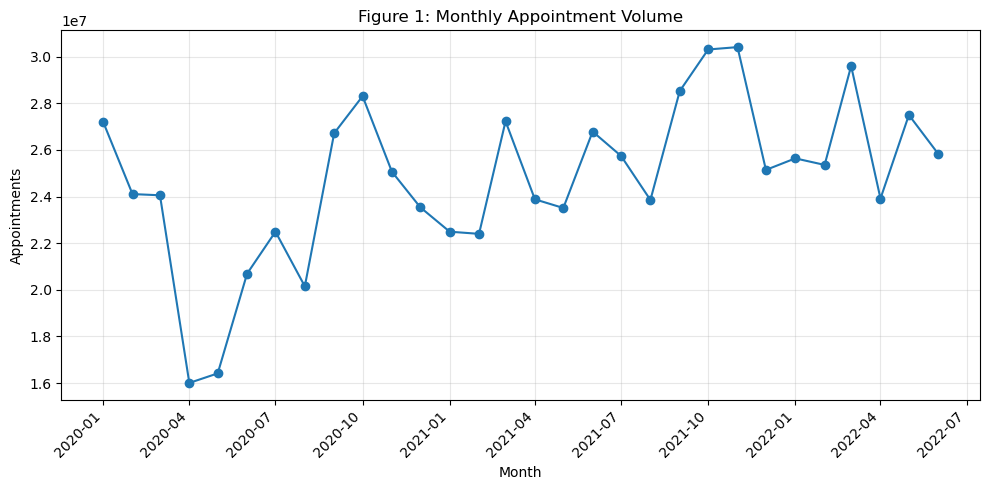

In [33]:
# ------------------------------------------------------------
# 2. Monthly Appointment Volume
# ------------------------------------------------------------
monthly = (
    ar
    .groupby(ar['appointment_month'].dt.to_period('M'))['count_of_appointments']
    .sum()
    .sort_index()
)
monthly.index = monthly.index.to_timestamp()

plt.figure(figsize=(10, 5))
plt.plot(monthly.index, monthly.values, marker='o')
plt.title('Figure 1: Monthly Appointment Volume')
plt.xlabel('Month')
plt.ylabel('Appointments')
plt.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

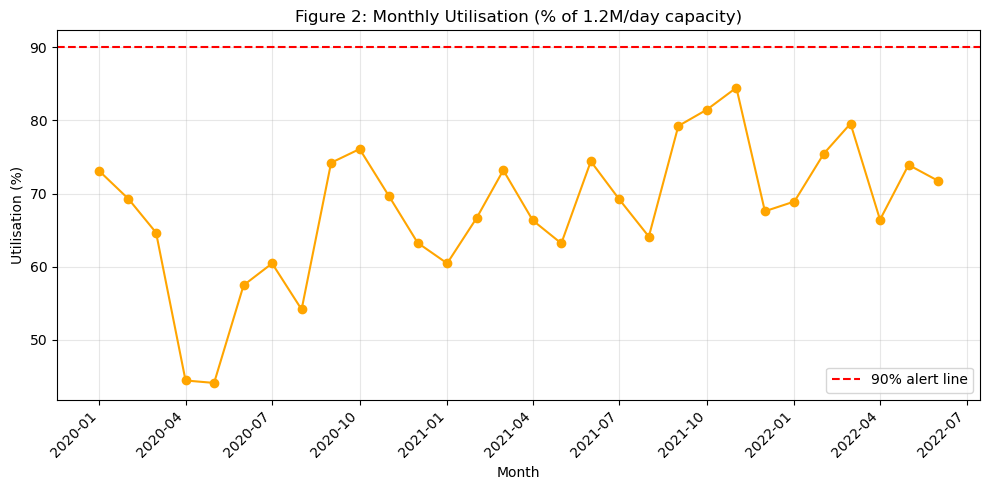

In [34]:
# ------------------------------------------------------------
# 3. Monthly Utilisation vs Capacity
# ------------------------------------------------------------
# Assume 1.2M appointments capacity per day
daily_capacity = 1_200_000
days = np.array([d.days_in_month for d in monthly.index])
monthly_capacity = days * daily_capacity
monthly_util = monthly.values / monthly_capacity * 100

plt.figure(figsize=(10, 5))
plt.plot(monthly.index, monthly_util, marker='o', color='orange')
plt.title('Figure 2: Monthly Utilisation (% of 1.2M/day capacity)')
plt.xlabel('Month')
plt.ylabel('Utilisation (%)')
plt.axhline(90, color='red', linestyle='--', label='90% alert line')
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

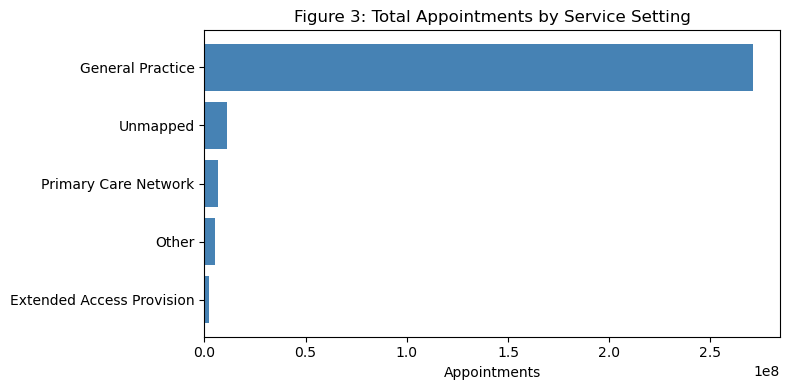

In [35]:
# ------------------------------------------------------------
# 4. Service Setting Totals
# ------------------------------------------------------------
service_totals = (
    nc
    .groupby('service_setting')['count_of_appointments']
    .sum()
    .sort_values(ascending=False)  # largest first
)

plt.figure(figsize=(8, 4))
plt.barh(service_totals.index, service_totals.values, color='steelblue')
plt.title('Figure 3: Total Appointments by Service Setting')
plt.xlabel('Appointments')

# Flip so the first (largest) bar appears at the top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

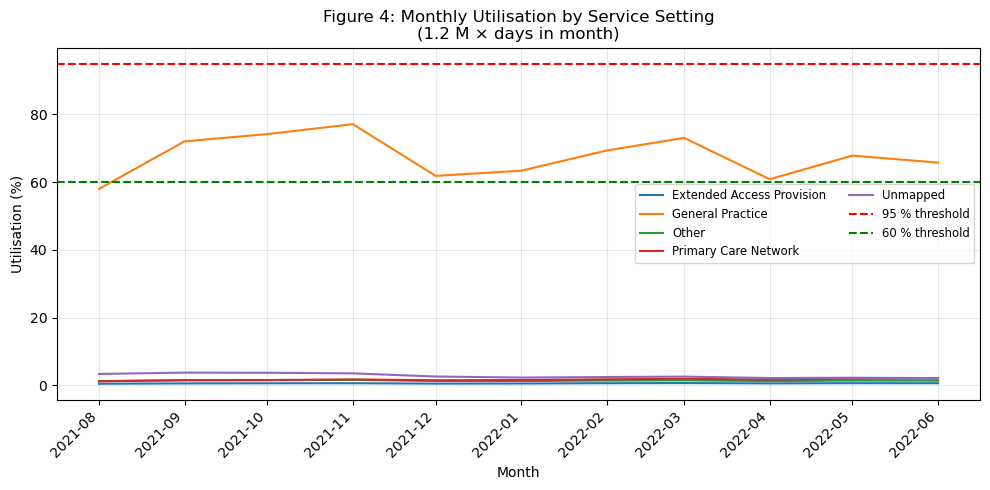

In [36]:
# ------------------------------------------------------------
# 5. Utilisation by Service Setting over Time
# ------------------------------------------------------------
# 1) Build ms: monthly totals per setting
ms = (
    nc
    .groupby([nc['appointment_month'].dt.to_period('M'), 'service_setting'])
    ['count_of_appointments']
    .sum()
    .unstack(fill_value=0)
)
ms.index = ms.index.to_timestamp()  # convert PeriodIndex to TimestampIndex

# 2) Build a Series of the monthly capacity (1.2 M × days in that month)
daily_cap = 1_200_000
monthly_capacity = pd.Series(
    [d.days_in_month * daily_cap for d in ms.index],
    index=ms.index
)

# 3) Compute utilisation (%) by setting
util_by_setting = ms.div(monthly_capacity, axis=0) * 100

# 4) Plot
plt.figure(figsize=(10, 5))
for setting in util_by_setting.columns:
    plt.plot(
        util_by_setting.index,
        util_by_setting[setting],
        label=setting
    )

# threshold lines
plt.axhline(95, color='red', linestyle='--', label='95 % threshold')
plt.axhline(60, color='green', linestyle='--', label='60 % threshold')

plt.title('Figure 4: Monthly Utilisation by Service Setting\n(1.2 M × days in month)')
plt.xlabel('Month')
plt.ylabel('Utilisation (%)')
plt.legend(ncol=2, fontsize='small')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

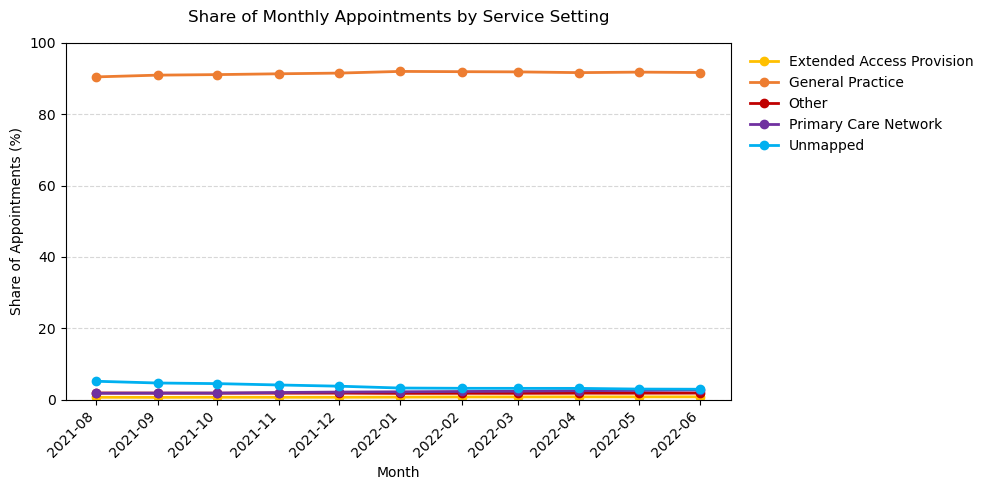

In [37]:
# ------------------------------------------------------------
# 6. Share of Appointments by Service Setting (complete)
# ------------------------------------------------------------
# 1) Recompute monthly totals per service setting
ms = (
    nc
    .groupby([nc['appointment_month'].dt.to_period('M'), 'service_setting'])
    ['count_of_appointments']
    .sum()
    .unstack(fill_value=0)
)
# Convert PeriodIndex back to Timestamp for plotting
ms.index = ms.index.to_timestamp()

# 2) Compute each setting’s share of that month’s total
share = ms.div(ms.sum(axis=1), axis=0) * 100

# 3) Define the exact colour palette
palette = {
    'Extended Access Provision': '#FFC000',  # gold
    'General Practice':            '#ED7D31',  # orange-red
    'Other':                       '#C00000',  # deep red
    'Primary Care Network':        '#7030A0',  # purple
    'Unmapped':                    '#00B0F0',  # sky blue
}

# 4) Plot
plt.figure(figsize=(10, 5))
for setting, series in share.items():
    plt.plot(
        share.index,
        series,
        label=setting,
        color=palette.get(setting, 'grey'),
        marker='o',
        markersize=6,
        linewidth=2
    )

plt.title('Share of Monthly Appointments by Service Setting', pad=15)
plt.xlabel('Month')
plt.ylabel('Share of Appointments (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.01, 1),
    frameon=False
)
plt.tight_layout()
plt.show()

/var/folders/xf/k5svpz9n5pj_nr5ldxk67d380000gp/T/ipykernel_3285/814944277.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ad['appointment_date'] = pd.to_datetime(ad['appointment_date'])


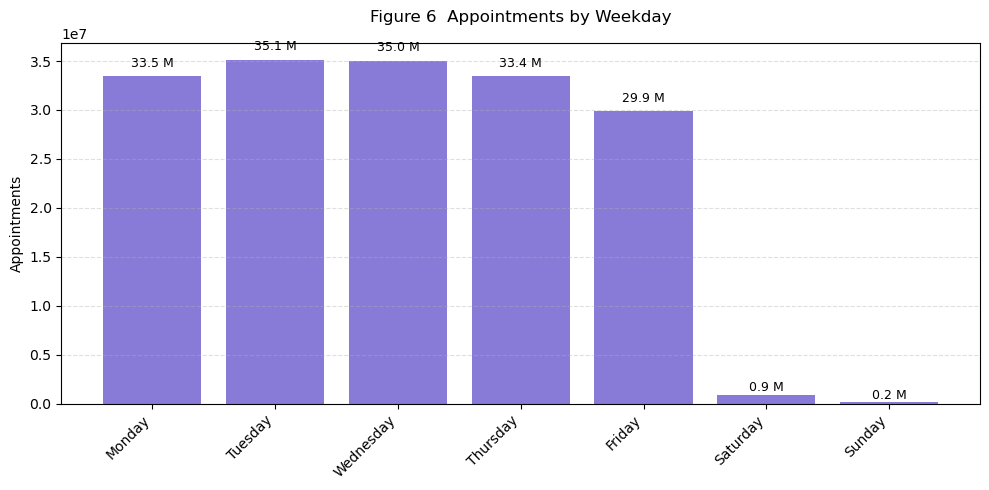

In [38]:
# ------------------------------------------------------------
# 7. Weekday Load Imbalance
# ------------------------------------------------------------
# ad contains appointment_date + count_of_appointments
ad['appointment_date'] = pd.to_datetime(ad['appointment_date'])
ad['weekday'] = ad['appointment_date'].dt.day_name()

# Aggregate total appointments by weekday in calendar order
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
wd_counts = (
    ad
    .groupby('weekday')['count_of_appointments']
    .sum()
    .reindex(weekday_order)
)

# Plot
plt.figure(figsize=(10,5))
plt.bar(wd_counts.index, wd_counts.values,
        color='slateblue', alpha=0.8)
plt.title('Figure 6  Appointments by Weekday', pad=15)
plt.ylabel('Appointments')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Optional: annotate the bars
for i, v in enumerate(wd_counts.values):
    plt.text(i, v+v*0.02, f'{v/1e6:.1f} M', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

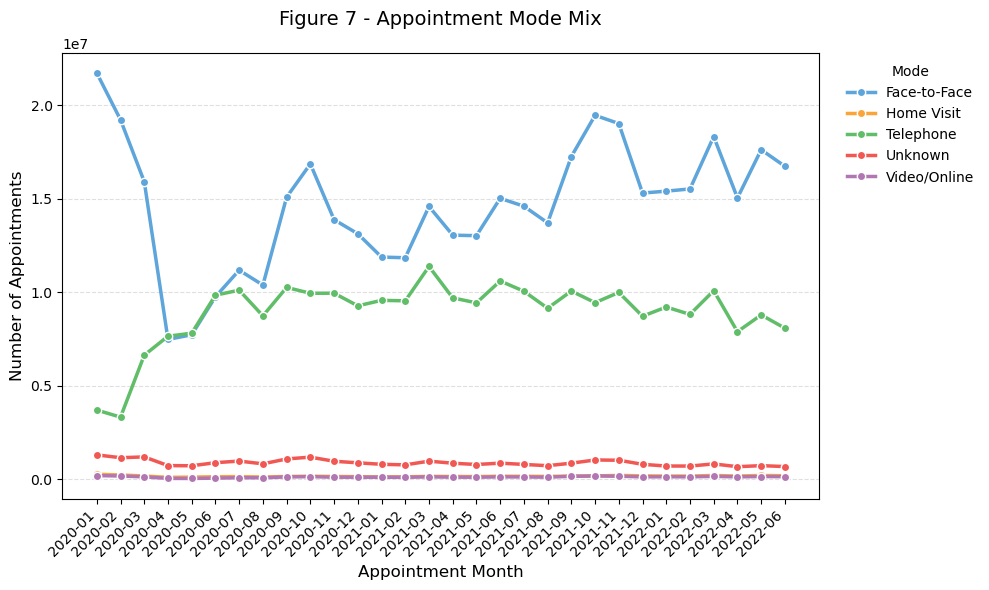

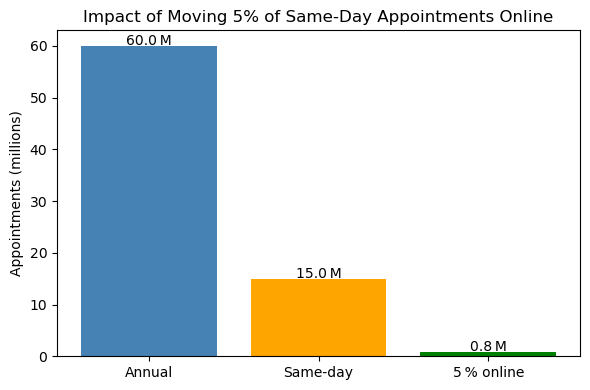

In [39]:
# ------------------------------------------------------------
# 8. Appointment Mode Mix
# ------------------------------------------------------------
# Ensure ar['appointment_month'] is a datetime
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'])

# Detect mode column
mode_col = 'appointment_mode' if 'appointment_mode' in ar.columns else 'appointment_booking_type'

# Aggregate: sum appointments by month + mode
mode_df = (
    ar
    .groupby(['appointment_month', mode_col])['count_of_appointments']
    .sum()
    .reset_index()
)

# Prepare for plotting
mode_df['month_str'] = mode_df['appointment_month'].dt.strftime('%Y-%m')

# Define a consistent color palette
palette = {
    'Face-to-Face':   '#5DA5DA',  # blue
    'Telephone':      '#60BD68',  # green
    'Unknown':        '#F15854',  # red
    'Video/Online':   '#B276B2',  # purple
    'Home Visit':     '#FAA43A'   # orange
}

plt.figure(figsize=(10, 6))
for mode in mode_df[mode_col].unique():
    subset = mode_df[mode_df[mode_col] == mode]
    plt.plot(
        subset['month_str'],
        subset['count_of_appointments'],
        marker='o',
        markersize=6,
        linewidth=2.5,
        color=palette.get(mode, 'gray'),
        label=mode,
        markeredgecolor='white'
    )

# Styling
plt.title('Figure 7 - Appointment Mode Mix', pad=20, fontsize=14)
plt.xlabel('Appointment Month', fontsize=12)
plt.ylabel('Number of Appointments', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Legend outside the plot
plt.legend(title='Mode', loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False)

plt.tight_layout()
plt.show()

# Impact of moving modes

df = pd.DataFrame({
    'Metric': ['Annual', 'Same‑day', '5 % online'],
    'Appointments': [60_000_000, 15_000_000, 750_000]
})

plt.figure(figsize=(6,4))
plt.bar(df['Metric'], df['Appointments']/1_000_000, color=['steelblue','orange','green'])
plt.ylabel('Appointments (millions)')
plt.title('Impact of Moving 5% of Same‑Day Appointments Online')

for idx, val in enumerate(df['Appointments']):
    plt.text(idx, val/1_000_000 + 0.2, f"{val/1_000_000:.1f} M", ha='center')

plt.tight_layout()
plt.show()

/var/folders/xf/k5svpz9n5pj_nr5ldxk67d380000gp/T/ipykernel_3285/2436417567.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: 100 * (1 - g.loc[g['appointment_status']=='Attended','count_of_appointments'].sum()


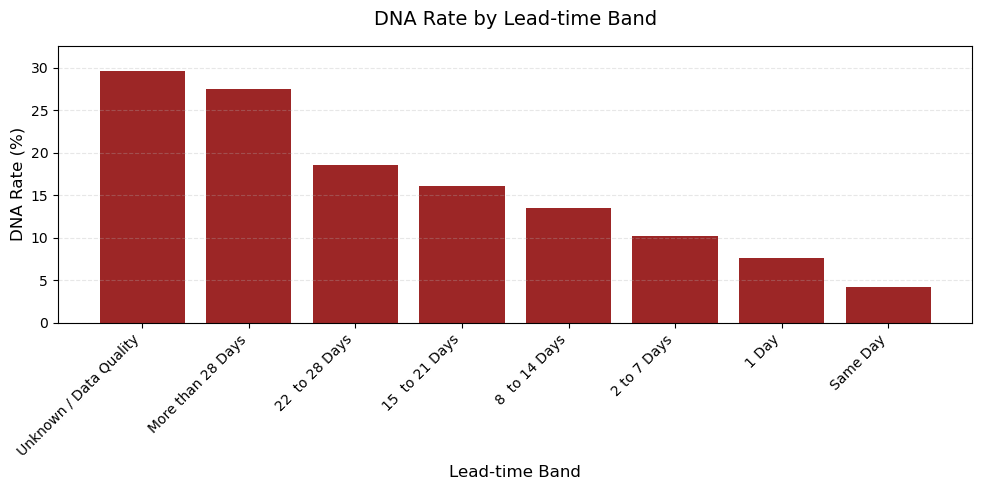

In [40]:
# ------------------------------------------------------------
# 9. Lead-time Influence on Attendance (DNA)
# ------------------------------------------------------------
# 1. Compute DNA rate by lead-time band
# -------------------------------------
# Group on the time-between field and calculate % DNA = 100*(1 – attended/total)
dna_rates = (
    ar
    .groupby('time_between_book_and_appointment')
    .apply(lambda g: 100 * (1 - g.loc[g['appointment_status']=='Attended','count_of_appointments'].sum()
                            / g['count_of_appointments'].sum()))
    .dropna()
)

# 2. Sort descending (so Unknown/Data Quality is first)
# -----------------------------------------------------
dna_rates = dna_rates.sort_values(ascending=False)

# 3. Plot
# -------
plt.figure(figsize=(10, 5))
plt.bar(
    dna_rates.index.astype(str),
    dna_rates.values,
    color='darkred',
    edgecolor='none',
    alpha=0.85
)
plt.title('DNA Rate by Lead-time Band', pad=15, fontsize=14)
plt.ylabel('DNA Rate (%)', fontsize=12)
plt.xlabel('Lead-time Band', fontsize=12)

# Rotate labels & tighten
plt.xticks(rotation=45, ha='right')
plt.ylim(0, dna_rates.max() * 1.1)   # add a little headroom above the tallest bar
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Lead-time bands present in data: ['1 Day', '15  to 21 Days', '2 to 7 Days', '22  to 28 Days', '8  to 14 Days', 'More than 28 Days', 'Same Day', 'Unknown / Data Quality']
Plot order (largest first): ['Same Day', '2 to 7 Days', '8  to 14 Days', '1 Day', '15  to 21 Days', '22  to 28 Days', 'More than 28 Days', 'Unknown / Data Quality']


,Lead-time Band,Appointments
0,Same Day,342747171
1,2 to 7 Days,153794531
2,8 to 14 Days,86846519
3,1 Day,67716097
4,15 to 21 Days,42710574
5,22 to 28 Days,25536541
6,More than 28 Days,23050987
7,Unknown / Data Quality,402105


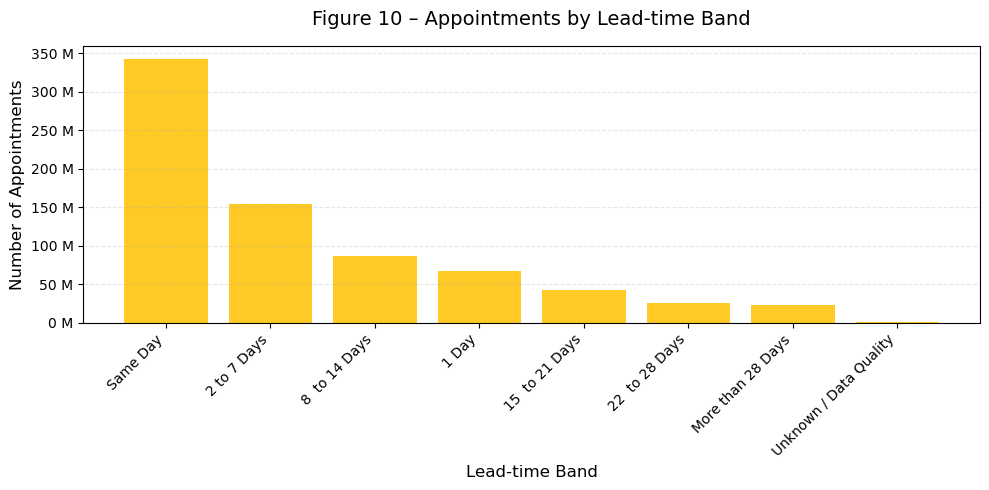

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ------------------------------------------------------------
# Figure 10 – Appointments by Lead-time Band
# ------------------------------------------------------------

# 1. Inspect exactly which bands live in ar
bands = ar['time_between_book_and_appointment'].dropna().unique().tolist()
print('Lead-time bands present in data:', bands)

# 2. Sum true appointment volumes by band
lead_counts = (
    ar
    .groupby('time_between_book_and_appointment')['count_of_appointments']
    .sum()
)

# 3. Derive the plotting order: sort bands by descending volume
band_order = lead_counts.sort_values(ascending=False).index.tolist()
print('Plot order (largest first):', band_order)

# 4. Reorder the Series
ordered_counts = lead_counts.loc[band_order]

# 5. Display the table for verification
lead_table = ordered_counts.reset_index().rename(
    columns={
        'time_between_book_and_appointment': 'Lead-time Band',
        'count_of_appointments':              'Appointments'
    }
)
display(lead_table)

# 6. Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    ordered_counts.index,
    ordered_counts.values,
    color='#FFC000',
    alpha=0.85
)

# 7. Y-axis in millions for readability
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{x/1e6:.0f} M')
)

# 8. Styling
ax.set_title('Figure 10 – Appointments by Lead-time Band', pad=15, fontsize=14)
ax.set_xlabel('Lead-time Band', fontsize=12)
ax.set_ylabel('Number of Appointments', fontsize=12)
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

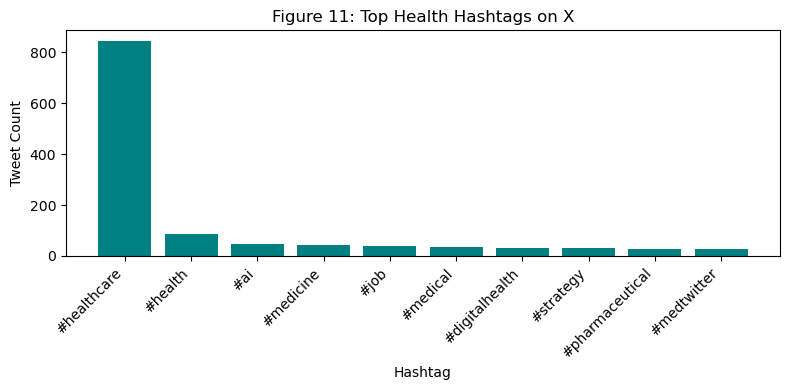

In [42]:
# ------------------------------------------------------------
# 11. Twitter Hashtag Frequency
# ------------------------------------------------------------
hashtags = (
    tw['tweet_entities_hashtags']
    .dropna()
    .str.lower()
    .str.replace(' ', '')
    .str.split(',')
    .explode()
)
top_hashtags = hashtags.value_counts().head(10)

plt.figure(figsize=(8, 4))
plt.bar(top_hashtags.index, top_hashtags.values, color='teal')
plt.title('Figure 11: Top Health Hashtags on X')
plt.xlabel('Hashtag')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

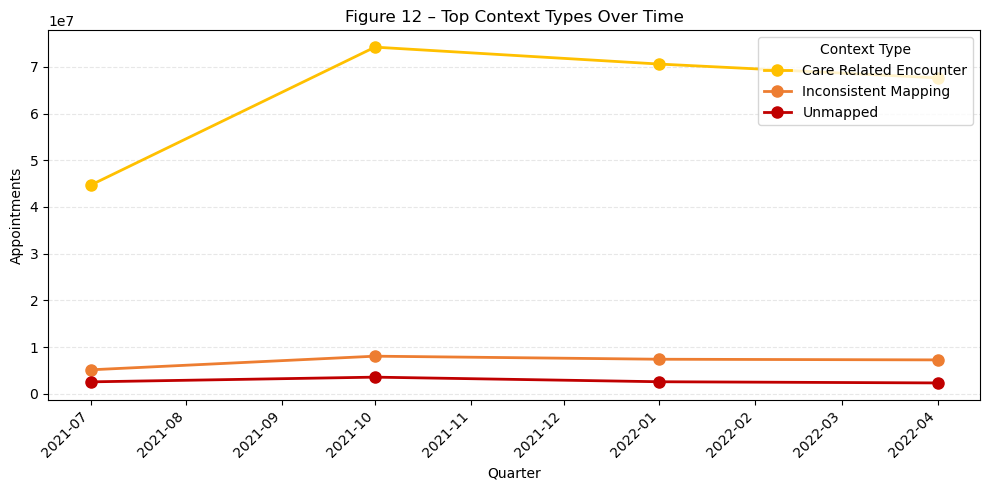

In [43]:
# ------------------------------------------------------------
# 12. Top Context Types Over Time (Figure 12)
# ------------------------------------------------------------
# Ensure appointment_month is datetime
nc['appointment_month'] = pd.to_datetime(nc['appointment_month'])

# Create quarter start date for grouping
nc['quarter_start'] = (
    nc['appointment_month']
    .dt.to_period('Q')
    .dt.to_timestamp(how='start')
)

# Aggregate appointments by quarter and context type
ctx_q = (
    nc
    .groupby(['quarter_start', 'context_type'])['count_of_appointments']
    .sum()
    .unstack(fill_value=0)
)

# Identify top 3 context types by total volume
top3 = ctx_q.sum(axis=0).sort_values(ascending=False).head(3).index.tolist()
ctx_top3 = ctx_q[top3]

# Define colors matching the report
palette = {
    'Care Related Encounter': '#FFC000',
    'Inconsistent Mapping':   '#ED7D31',
    'Unmapped':                '#C00000'
}

# Plot
plt.figure(figsize=(10, 5))
for ctx in top3:
    plt.plot(
        ctx_top3.index,
        ctx_top3[ctx],
        marker='o',
        markersize=8,
        linewidth=2,
        color=palette.get(ctx, 'gray'),
        label=ctx
    )

# Styling
plt.title('Figure 12 – Top Context Types Over Time')
plt.xlabel('Quarter')
plt.ylabel('Appointments')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Context Type', loc='upper right')

plt.tight_layout()
plt.show()

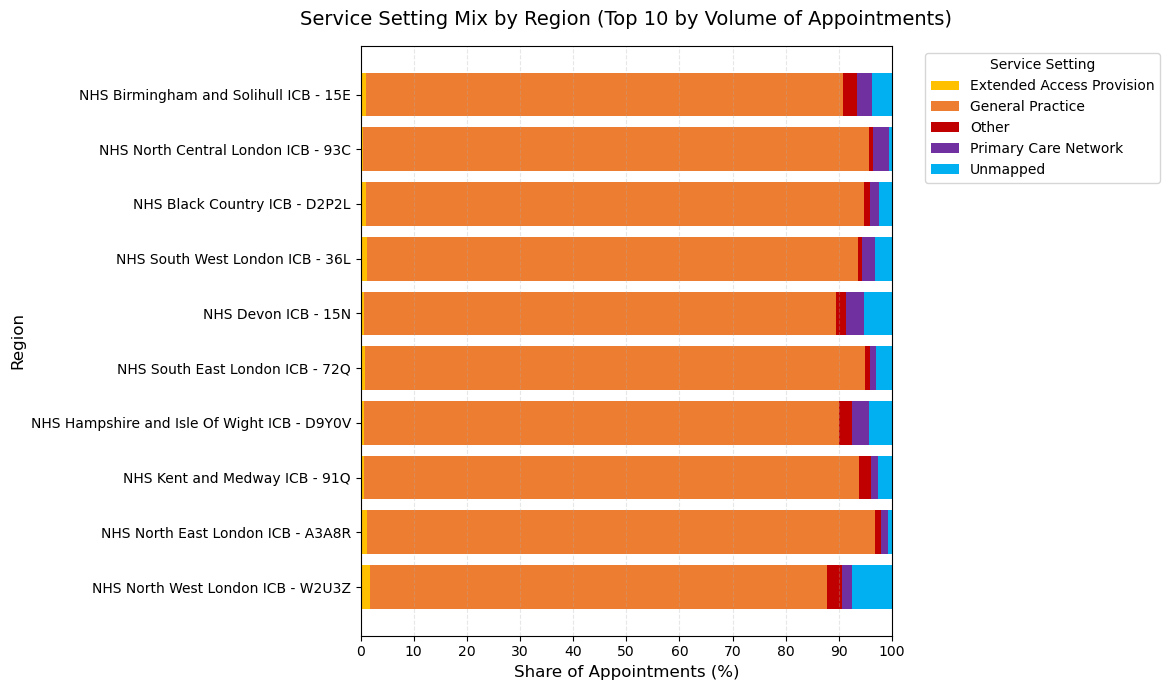

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Service Setting Mix by Region (Horizontal Stacked Bar)
# ------------------------------------------------------------

# 1. Aggregate appointment volumes by region and service setting
region_setting = (
    nc.groupby(['sub_icb_location_name', 'service_setting'])['count_of_appointments']
    .sum()
    .unstack(fill_value=0)
)

# 2. Compute share (%) of each service setting per region
region_share = region_setting.div(region_setting.sum(axis=1), axis=0) * 100

# 3. Select top 10 regions by total appointment volume
region_totals = region_setting.sum(axis=1)
top_regions = region_totals.sort_values(ascending=False).head(10).index
region_share_top = region_share.loc[top_regions]

# 4. Plot horizontal stacked bar chart
palette = {
    'General Practice':            '#ED7D31',
    'Primary Care Network':        '#7030A0',
    'Extended Access Provision':   '#FFC000',
    'Other':                       '#C00000',
    'Unmapped':                    '#00B0F0',
}

fig, ax = plt.subplots(figsize=(12, 7))

# Initialize left offset for stacking
left = np.zeros(len(region_share_top))

# Plot each service setting in the defined order
for setting in region_share_top.columns:
    values = region_share_top[setting].values
    ax.barh(region_share_top.index, values, left=left,
            color=palette.get(setting, 'grey'), label=setting)
    left += values

# Styling
ax.set_title('Service Setting Mix by Region (Top 10 by Volume of Appointments)', pad=15, fontsize=14)
ax.set_xlabel('Share of Appointments (%)', fontsize=12)
ax.set_ylabel('Region', fontsize=12)
ax.set_xlim(0, 100)
ax.legend(title='Service Setting', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='x', linestyle='--', alpha=0.3)
plt.xticks(np.arange(0, 101, 10))
plt.tight_layout()

plt.show()
